The train folder contains 25,000 images of dogs and cats. Each image in this folder has the label as part of the filename. The test folder contains 12,500 images, named according to a numeric id.
For each image in the test set, you should predict a probability that the image is a dog (1 = dog, 0 = cat).  
We will use image size of (224 x 224) and batch size of 64.

<a id = 'sec1'></a>
# Load Required Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
import cv2
from tqdm import tqdm          #Used for the purpose of showing iterations getting loaded in bar kind of form
from random import shuffle
from zipfile import ZipFile
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

2025-04-21 19:35:32.860076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745264133.050074      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745264133.101235      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


weight_loc = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'  
We'll not be using this path directly because it will cause some dimension error instead we will download weights of imagenet.
Here is the explanation:
https://stackoverflow.com/questions/60119041/failed-to-load-keras-resnet50-model-offline-using-weight-file

<a id = 'sec2'></a>
# Read the Data

We will unzip train and test directory using zipfile library.

In [3]:
zip_file = glob.glob('../input/dogs-vs-cats-redux-kernels-edition/*.zip')  #return any files with .zip extension
print(zip_file)

#extract file into a temp folder
def extract_zip(file):
    with ZipFile(file,'r') as zip_ref:
        zip_ref.extractall('.')
        
#extract both train and test1 zip
for files in zip_file:
    extract_zip(files)

['../input/dogs-vs-cats-redux-kernels-edition/train.zip', '../input/dogs-vs-cats-redux-kernels-edition/test.zip']


In [4]:
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

train_path = get_path('../working/train')
test_path = get_path('../working/test')

<a id = 'sec3'></a>
# Visualizing Data

First we will one hot encode the categories(cat and dog) for the purpose of data exploration.

In [5]:
#this labelling function is just for the visualization, we'll have separate one for preprocessing.
def label_img(img):
    category = img.split('.')[-3]
    if category == 'cat': return [1,0]
    elif category == 'dog': return [0,1]

#Process the data, here we're converting images into numpy array. This function takes image data, image directory, a boolean as an argument.
def process_data(img_data, data_dir, isTrain=True):
    data_df = []
    for img in tqdm(img_data):
        path = os.path.join(data_dir,img)         #Assigning path to images by concatenating directory and images
        if(isTrain):
            label = label_img(img)            #Calling label_img to assign labels to image present in training directory
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        data_df.append([np.array(img),np.array(label)])          #append image and labels as numpy array in data_df list
    shuffle(data_df)
    return data_df

In [6]:
#We will plot the images of dogs and cats and display the assigned label above image
def show_images(data, isTest=False):
    f, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (15,15))
    for i,data in enumerate(data[:25]):              #enumerate helps in keeping track of count of iterations
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)                    #to get maximum indices of an array
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')                 #removing axis for better look
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

<a id = 'subsec2'></a>
<span style="color:red;font-size:20px"> Visualizing Training Set </span>

100%|██████████| 25000/25000 [00:27<00:00, 897.54it/s]


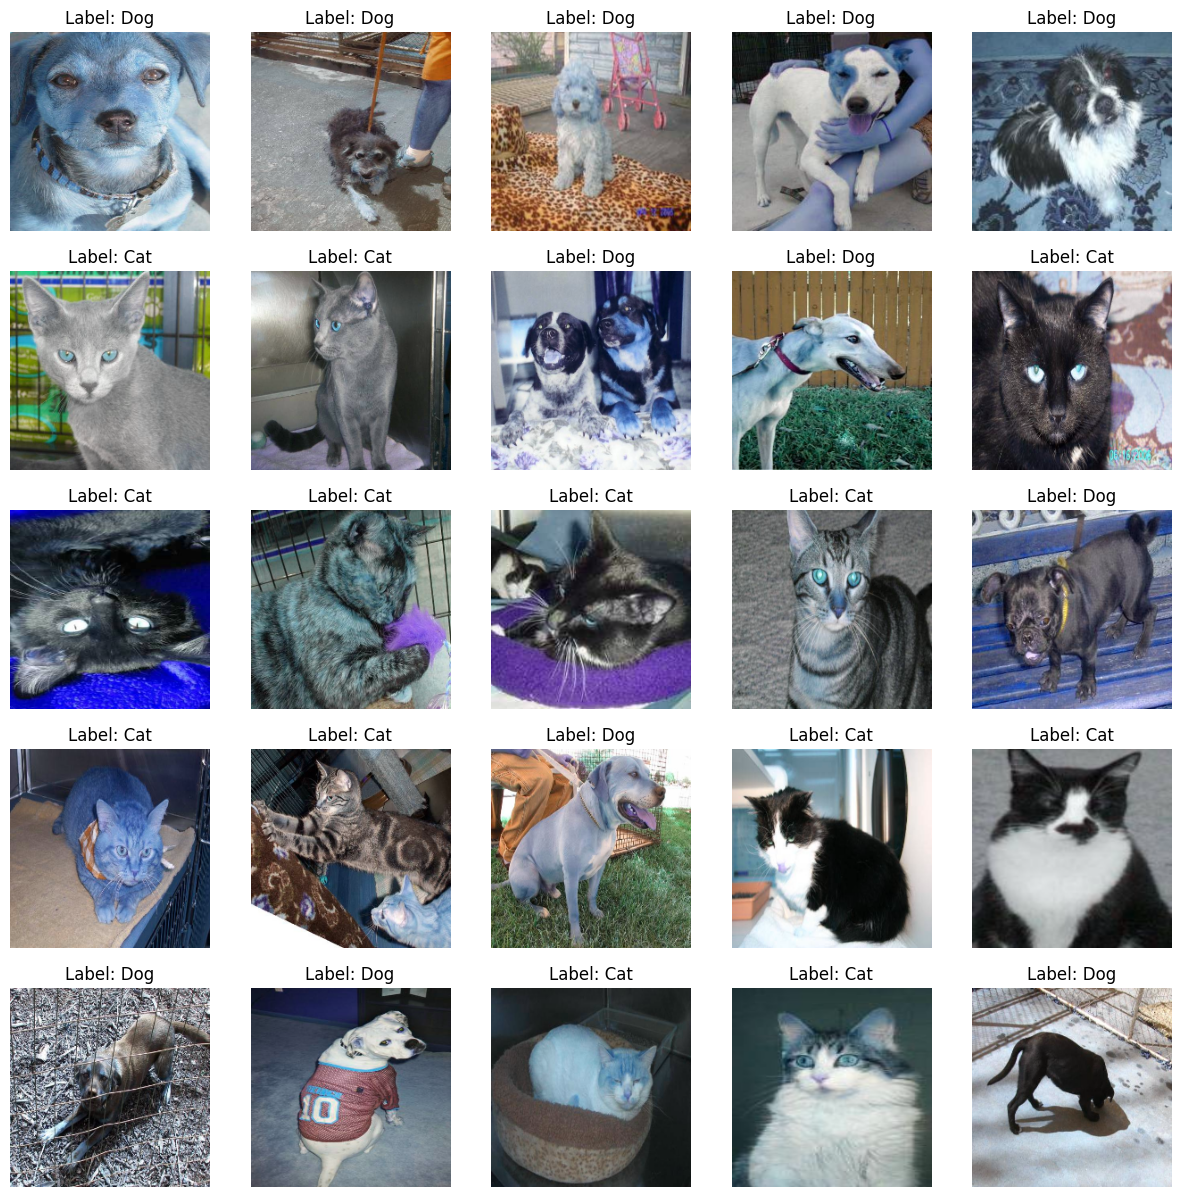

In [7]:
train = process_data(train_path, './train/')
show_images(train)

<a id = 'subsec3'></a>
<span style="color:red;font-size:20px"> Visualizing Test Set </span>

100%|██████████| 12500/12500 [00:13<00:00, 903.48it/s]


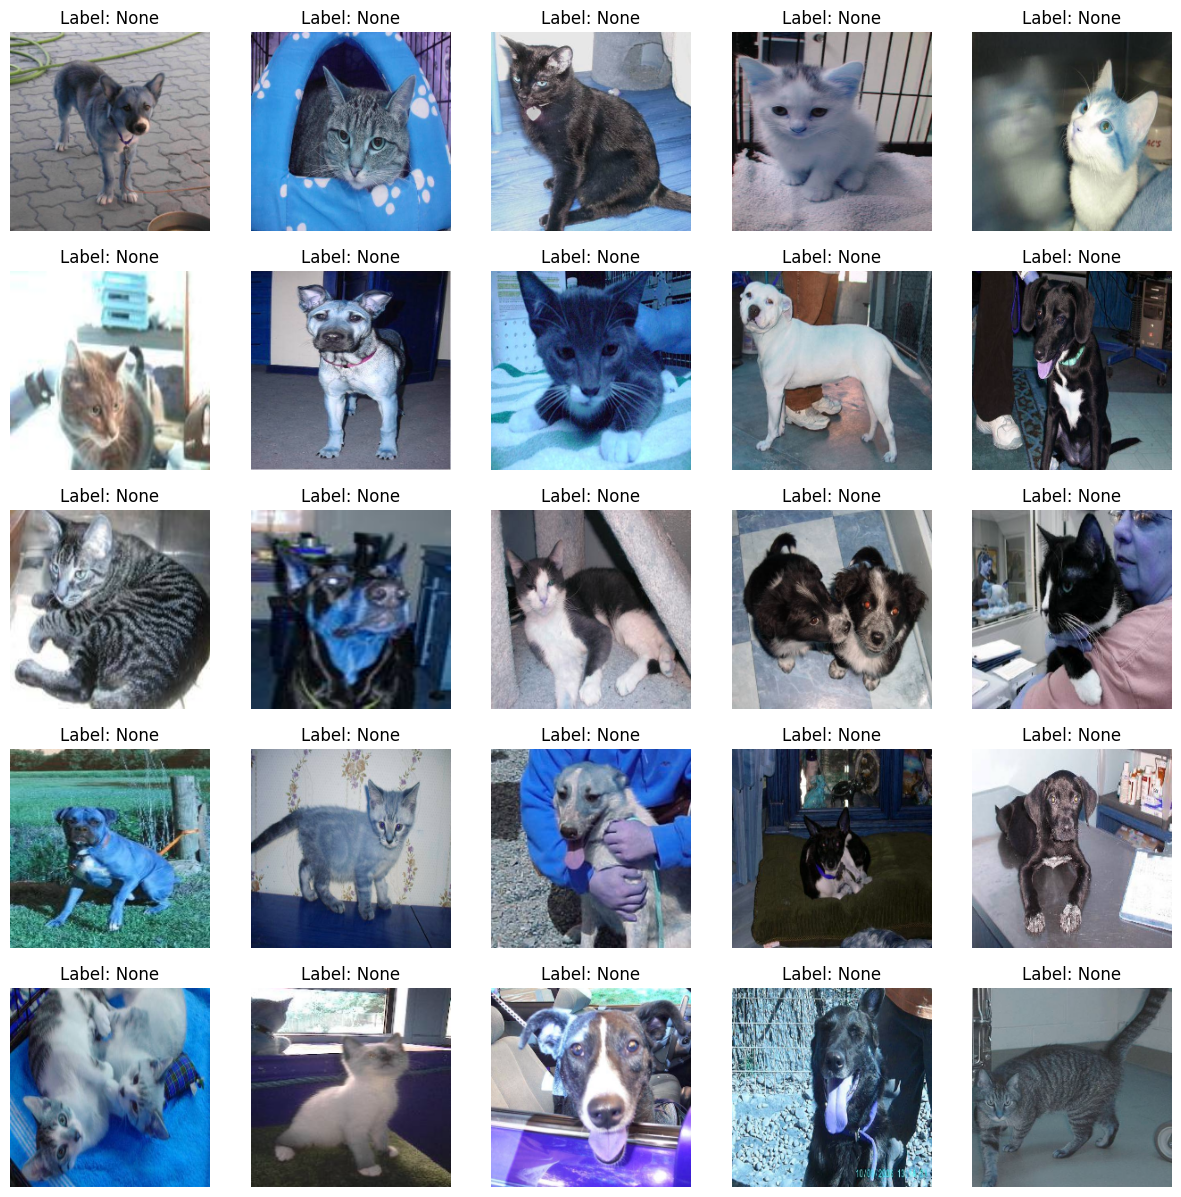

In [8]:
test = process_data(test_path, './test/', False)
show_images(test,True)

<a id = 'sec4'></a>
# Preprocessing Data

<a id = 'subsec11'></a>
<span style="color:green;font-size:20px"> Convert data into dataframe </span>

In our data formatting, we will generate the respective labels for dogs (1) and cats (0) for our training data. File path will also be collected as a column for our dataframe so that it can be used to load and train our images.  

file.split('.')[0] means -
* the particular filename is a String separated by dots.
* line.split(".")[0] returns the 1st item of the array. (the actual file looks like "cat.134.jpg")

In [9]:
#We will use below function to label data
def get_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label

label = get_label('../working/train')

#In case of train_test_split, allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes. Convert the images and labels into dataframe.
df = pd.DataFrame({'filename': train_path, 'label': label})
df.head()

filename label
0   cat.5906.jpg     0
1   cat.5169.jpg     0
2  cat.12041.jpg     0
3   cat.3423.jpg     0
4    dog.708.jpg     1

In [10]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 123)
print(train_df.shape)
print(valid_df.shape)

(20000, 2)
(5000, 2)


<a id = 'subsec12'></a>
<span style="color:green;font-size:20px"> Generating mini batches for training </span>  

We'll use ImageDataGenerator for preprocessing. It helps in data augmentation and helps to get better accuracy by making data flow in batches. Mini-Batch Gradient Descent uses a mini-batches of training example for each gradient calculation; which makes convergence faster, and at the same time, utilise the speed up from vectorization.

Here we'll assign preprocess_input to preprocessing_function argument of ImageDataGenerator because it has better advantage on accuracy.

In [11]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(rotation_range = 10, zoom_range = 0.1, horizontal_flip = True, fill_mode = 'nearest', 
                                   width_shift_range = 0.1, height_shift_range = 0.1, preprocessing_function = preprocess_input)

#flow_from_dataframe() method will accept dataframe with filenames as x_column and labels as y_column to generate mini-batches
train_gen = train_datagen.flow_from_dataframe(train_df, directory = '../working/train', x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 64, class_mode='binary')

#we do not augment validation data.
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, directory = '../working/train', x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 64, class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


<a id = 'sec5'></a>
# Model

<a id = 'subsec21'></a>
<span style="color:green;font-size:20px"> Prepare the model </span>  

We initialize the ResNet-50 model, adding an additional last layer of type Dense, with sigmoid activation function.
We also set the first layer of the model to be not trainable, becaise ResNet-50 model was already trained.

In [12]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))
model.add(Dense(1, activation = 'sigmoid'))

model.layers[0].trainable = False 

I0000 00:00:1745264204.464847      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


<span style = 'color:green;font-size:20px'> Model summary </span>  

We plot the model description. We can see that the ResNet-50 model represent the 1st layer of our model, of type Model.

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

<span style="color:green;font-size:20px"> Compile the model </span>  

We compile the model, using a adam optimized, the loss function as binary crossentropy and the metric accuracy.

In [14]:
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy')

<span style = 'color:green;font-size:20px'> Callback </span>

Best weight will be stored in 'dogcat.weights.best.hdf5'

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(
    filepath='dogcat.weights.best.weights.h5',
    save_best_only=True,
    save_weights_only=True
)


<a id = 'subsec22'></a>
<span style = 'color:green;font-size:20px'> Train the model </span>

In [16]:
model.fit(train_gen, epochs=10, validation_data=valid_gen, callbacks=[checkpointer])


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745264228.385387      61 service.cc:148] XLA service 0x7d4ff0002890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745264228.386135      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745264229.708152      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/313 ━━━━━━━━━━━━━━━━━━━━ 27s 89ms/step - accuracy: 0.6055 - loss: 2.0299   

I0000 00:00:1745264234.074279      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 251s 739ms/step - accuracy: 0.9219 - loss: 0.3700 - val_accuracy: 0.9794 - val_loss: 0.1000
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 228s 713ms/step - accuracy: 0.9804 - loss: 0.0919 - val_accuracy: 0.9764 - val_loss: 0.1301
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 228s 714ms/step - accuracy: 0.9825 - loss: 0.0815 - val_accuracy: 0.9834 - val_loss: 0.0747
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 226s 708ms/step - accuracy: 0.9852 - loss: 0.0639 - val_accuracy: 0.9828 - val_loss: 0.0761
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 228s 711ms/step - accuracy: 0.9840 - loss: 0.0917 - val_accuracy: 0.9848 - val_loss: 0.0774
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 226s 707ms/step - accuracy: 0.9885 - loss: 0.0496 - val_accuracy: 0.9776 - val_loss: 0.1559
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 229s 718ms/step - accuracy: 0.9866 - loss: 0.0657 - val_accuracy: 0.9858 - val_loss: 0.0823
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 227s 710ms/step - accuracy: 0.9854 - loss: 0.08

Plot the loss and accuracy curves.

<Axes: >

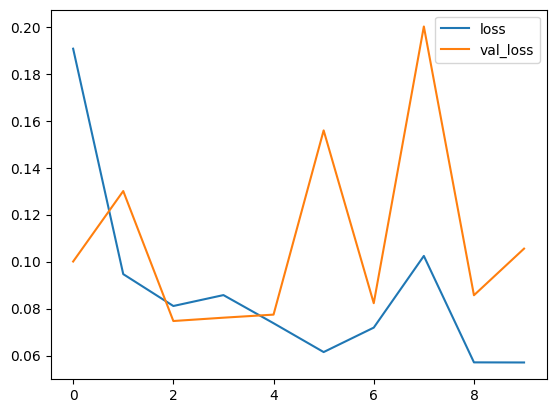

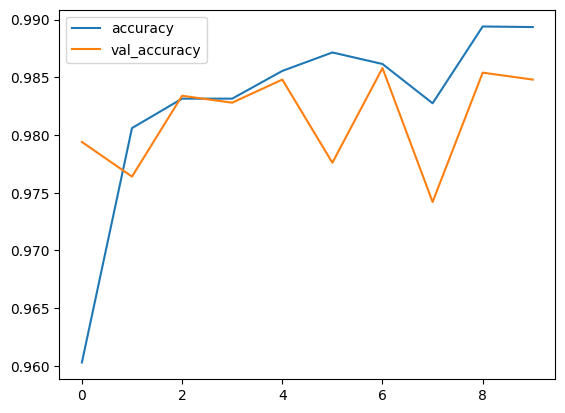

In [17]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['accuracy', 'val_accuracy']].plot()

<a id = 'sec6'></a>
# Results

In [18]:
#load the best weights saved using checkpointer
model.load_weights('dogcat.weights.best.weights.h5')

In [19]:
test_df = pd.DataFrame({'filename': test_path})    #test_path from function get_path

<a id = 'subsec31'></a>
<span style = 'color:green;font-size:20px'> Visualizing Predictions </span>

We will use test dataframe generated above and process the image. We will predict class using 'model.predict' and append the labels in a list.

In [20]:
test_sample = test_df.sample(n = 25, random_state = 123)    #Randomly sample 25 images from test directory for visualizing predictions

label_pred = []                         #list for predicted labels
for path in test_sample['filename'].to_numpy():
    full_path = '../working/test/'+path
    x = load_img(full_path, target_size=(224,224))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    
    out =  model.predict(img_array)    
    out = 'Dog' if float(out) >0.5 else 'Cat'
    label_pred.append(out)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/tmp/ipykernel_19/349104296.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out = 'Dog' if float(out) >0.5 else 'Cat'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


We will plot 25 random test images with their class using list of predicted labels.

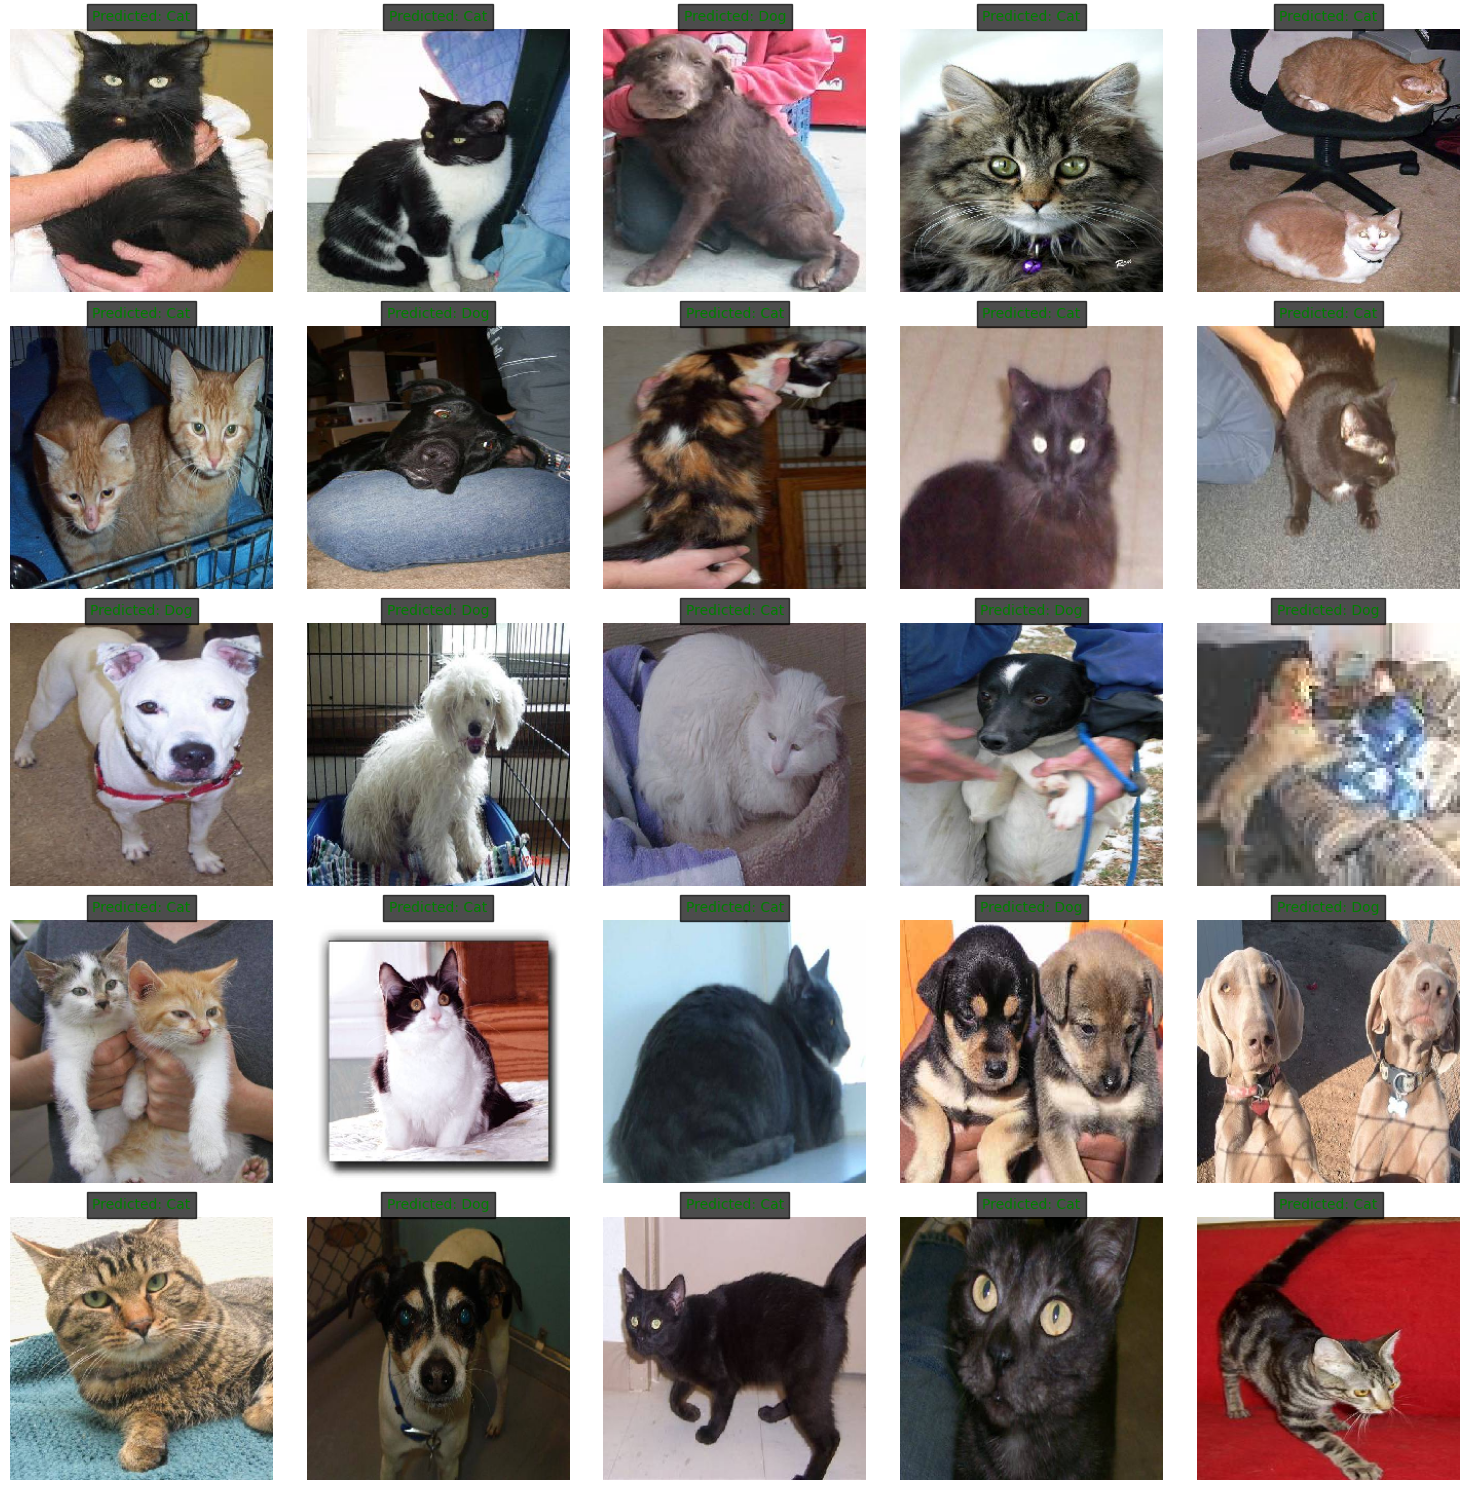

In [21]:
test_array = test_sample['filename'].to_numpy()            # convert dataframe to numpy array 

plt.figure(figsize=(15, 15))
for i in range(0, 25):
    plt.subplot(5, 5, i+1)
    img = test_array[i]
    path = '../working/test/' + img
    image = load_img(path, target_size=(256,256))
    
    plt.title('Predicted: {}'.format(label_pred[i]), color='green',fontsize= 10, bbox=dict(facecolor='black', alpha=0.7))
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()

In [22]:
#Generate mini batches of test data
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_gen = test_datagen.flow_from_dataframe(test_df, directory = '../working/test', batch_size = 64, x_col = 'filename', y_col = None, class_mode = None, shuffle = False,
                                            img_size = (224, 224))

Found 12500 validated image filenames.


In [23]:
# Performing predictions
prediction = model.predict(test_gen)
prediction = prediction.clip(min=0.005, max=0.995)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 229ms/step


In [24]:
submission_df = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')

for i, fname in enumerate(test_path):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    submission_df.at[index-1, 'label'] = prediction[i]
submission_df.to_csv('Cats&DogsSubmission.csv', index=False)

<a id = 'subsec32'></a>
<span style = 'color:green;font-size:20px'> Prepare Submission File </span>

In [25]:
submission_df.head()

id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005

<span style = 'color:green;font-size:20px'> Conclusion </span>  

Using a pretrained model for tensorflow, ResNet-50, with a Dense model with sigmoid activation added on top and training with a reduced set of we were able to obtain quite good model in terms of validation accuracy.
The model was used to predict the classes of the images from the independent test set and results were submitted to test the accuracy of the prediction with fresh data.